# 3. Использование диффузионных моделей для непарного переноса стиля

На 5 лекции мы имплементировали диффузионные модели для безусловной генерации и генерации при условии метки класса. В первой части домашки мы более глубоко исследовали генерацию при условии метки класса, а во второй — условную генерацию для решения парных (в т.ч. обратных) задач. Наконец, в третьей части мы разберем два простых метода, которые позволяют применять диффузионные модели для решения непарных задач перевода между доменами (непарного переноса стиля).

In [1]:
import math
import numpy as np
import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Resize, ToTensor

## Цветной MNIST

В домашке предлагается поработать с цветной модификацией датасета MNIST (код для покраски взят [у коллег](https://github.com/ngushchin/EntropicNeuralOptimalTransport/blob/main/src/tools.py) из Сколтеха). С одной стороны, такой датасет все еще оставляет возможность обучать диффузионные модели, но делает свойства модели более интерпретируемыми (например, в задачах условной генерации, таких, как дорисовывание, повышение разрешения и деблюринг, можно отследить корректное сохранение цвета изображения).

In [3]:
class ColoredMNIST(MNIST):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hues = 360 * torch.rand(super().__len__())

    def __len__(self):
        return super().__len__()

    def color_image(self, img, idx):
        img_min = 0
        a = (img - img_min) * (self.hues[idx] % 60) / 60
        img_inc = a
        img_dec = img - a

        colored_image = torch.zeros((3, img.shape[1], img.shape[2]))
        H_i = round(self.hues[idx].item() / 60) % 6

        if H_i == 0:
            colored_image[0] = img
            colored_image[1] = img_inc
            colored_image[2] = img_min
        elif H_i == 1:
            colored_image[0] = img_dec
            colored_image[1] = img
            colored_image[2] = img_min
        elif H_i == 2:
            colored_image[0] = img_min
            colored_image[1] = img
            colored_image[2] = img_inc
        elif H_i == 3:
            colored_image[0] = img_min
            colored_image[1] = img_dec
            colored_image[2] = img
        elif H_i == 4:
            colored_image[0] = img_inc
            colored_image[1] = img_min
            colored_image[2] = img
        elif H_i == 5:
            colored_image[0] = img
            colored_image[1] = img_min
            colored_image[2] = img_dec

        return colored_image

    def __getitem__(self, idx):
        img, label = super().__getitem__(idx)
        return self.color_image(img, idx), label

In [4]:
transform = Compose([Resize((32, 32)), ToTensor()])
data_train = ColoredMNIST(root='.', train=True, download=False, transform=transform)
#data_train = ColoredMNIST(root='.', train=True, download=True, transform=transform)
data_test = ColoredMNIST(root='.', train=False, download=False, transform=transform)
train_dataloader = DataLoader(data_train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(data_test, batch_size=64, shuffle=True)

In [5]:
from torchvision.utils import make_grid

def remove_ticks(ax):
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False,
        left=False,
        labelleft=False
    )

def remove_xticks(ax):
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False,
        left=True,
        labelleft=True
    )

def visualize_batch(img_vis, title='Семплы из цветного MNIST', nrow=10, ncol=4):
    img_grid = make_grid(img_vis, nrow=nrow)
    fig, ax = plt.subplots(1, figsize=(nrow, ncol))
    remove_ticks(ax)
    ax.set_title(title, fontsize=14)
    ax.imshow(img_grid.permute(1, 2, 0))
    plt.show()


## Предобученная диффузионная модель

Для дальнейшей работы с разного вида условной генерации нам понадобится предобученная **условная** диффузионная модель. Мы будем использовать простенькую архитектуру, которая была получена скрещиванием CUNet из того же [репозитория](https://github.com/ngushchin/EntropicNeuralOptimalTransport/blob/main/src/cunet.py) и части, кодирующей момент времени и метку класса, из SongUNet в [EDM](https://github.com/NVlabs/edm/blob/main/training/networks.py).

Такой выбор был мотивирован следующими наблюдениями:
* Готовые качественные архитектуры (те же SongUNet или DhariwalUNet) достаточно долго работают из-за своей глубины, что усложнит решение домашки, в которой, в основном, важны качественные результаты;
* Существующие имплементации этих архитектур достаточно абстрактно написаны, чтобы при первом знакомстве было удобно писать для них разного рода надстройки.

Архитектура CUNet представляет собой гораздо более легкую и неглубокую модель, за счет чего существенно ускоряет работу с ней и упрощает ее модификацию. Кодирование метки класса и момента времени везде более-менее одинаково (и включает в себя позиционное кодирование/positional encoding), поэтому выбор именно варианта из EDM не существенен.

Как и в семинаре, мы используем надстройку над архитектурой, которая делает все необходимые преобразования над входами: нормирование, взятие логарифма от уровня шума и т.д. Ее имплементация на этот раз взята из репозитория EDM, поэтому загрузка модели выглядит немного необычным образом. Можно не обращать внимания на устройство кода в следующих двух ячейках (небольшая часть кода из гитхаба EDM была изменена для удобства использования в ноутбуке).

In [6]:
#!git clone https://github.com/NVlabs/edm
!cp edm/training/networks.py edm/training/networks_copy.py
!cp fid.py edm/fid.py

In [7]:
def append_code(in_files, out_file):
    lines = ['\n']
    for in_file in in_files:
        with open(in_file, 'r') as f:
            for line in f:
                lines.append(line)

    with open(out_file, 'w') as f:
        for line in lines:
            f.write(line)

append_code(['edm/training/networks_copy.py', 'cunet.py'], 'edm/training/networks.py')

In [8]:
import pickle
%cd edm
from training.networks import EDMPrecond
from torch_utils import misc
from dnnlib import util
%cd ..

cond_model = EDMPrecond(img_resolution=32, img_channels=3, model_type='CUNet', noise_channels=128, base_factor=64, emb_channels=128, label_dim=11)
cond_model.eval().cuda()

with util.open_url('cond_cunet.pkl') as f:
    data = pickle.load(f)

misc.copy_params_and_buffers(src_module=data['ema'], dst_module=cond_model, require_all=True)
print(f"Модель имеет {sum(p.numel() for p in cond_model.parameters())} параметров")

/home/sudakovcom/Desktop/diffusion/HW_1/edm
/home/sudakovcom/Desktop/diffusion/HW_1
Модель имеет 17549763 параметров


Возьмем слегка модифицированный код для генерации и визуализации из семинара и посмотрим, как работает модель:

In [9]:
def normalize(x):
    return x / x.abs().max(dim=0)[0][None, ...]

def velocity_from_denoiser(x, model, sigma, class_labels=None, error_eps=1e-4, stochastic=False, cfg=0.0, **model_kwargs):
    sigma = sigma[:, None, None, None]
    cond_v = (model(x, sigma, class_labels, **model_kwargs) - x) / (sigma + error_eps)

    if cfg > 0.0:
        dummy_labels = torch.zeros_like(class_labels)
        dummy_labels[:, -1] = 1
        uncond_v = (model(x, sigma, dummy_labels, **model_kwargs) - x) / (sigma + error_eps)
        v = cond_v + cfg * (cond_v - uncond_v)
    else:
        v = cond_v

    if stochastic:
        v = v * 2

    return v

def get_timesteps(params):
    num_steps = params['num_steps']
    sigma_min, sigma_max = params['sigma_min'], params['sigma_max']
    rho = params['rho']

    step_indices = torch.arange(num_steps, device=params['device'])
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    t_steps = torch.cat([t_steps, torch.zeros_like(t_steps[:1])]) # t_N = 0
    return t_steps

def sample_euler(model, noise, params, class_labels=None, **model_kwargs):
    num_steps = params['num_steps']
    vis_steps = params['vis_steps']
    t_steps = get_timesteps(params)
    x = noise * params['sigma_max']
    x_history = [normalize(noise)]
    with torch.no_grad():
        for i in range(len(t_steps) - 1):
            t_cur = t_steps[i]
            t_next = t_steps[i + 1]
            t_net = t_steps[i] * torch.ones(x.shape[0], device=params['device'])
            x = x + velocity_from_denoiser(x, model, t_net, class_labels=class_labels, stochastic=params['stochastic'], cfg=params['cfg'], **model_kwargs) * abs(t_next - t_cur)
            if params['stochastic']:
                x = x + torch.randn_like(x) * torch.sqrt(torch.abs(t_next - t_cur) * 2 * t_cur)
            x_history.append(normalize(x).view(-1, 3, *x.shape[2:]))

    x_history = [x_history[0]] + x_history[::-(num_steps // (vis_steps - 2))][::-1] + [x_history[-1]]

    return x, x_history

def visualize_model_samples(model, params, labels_usage='dummy', class_labels=None, title='Семплы из модели', **model_kwargs):
    noise = torch.randn(40, 3, 32, 32, device=params['device'])
    if class_labels is None and labels_usage == 'dummy':
        class_labels = torch.zeros(40, 11, device=params['device'])
        class_labels[:, -1] = 1
    elif labels_usage == 'random':
        class_labels = torch.randint(low=0, high=10, size=(40,), device=params['device'])
        class_labels = (class_labels[:, None] == torch.arange(11, device=params['device'])[None, :]).float()

    out, trajectory = sample_euler(model, noise, params, class_labels=class_labels, **model_kwargs)
    out = out * 0.5 + 0.5
    visualize_batch(out.detach().cpu(), title=title)

Визуализируем условные семплы из модели (мы будем использовать коэффициент classifier-free guidance, равный 1).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.018846035..1.0186386].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03282863..1.0284488].


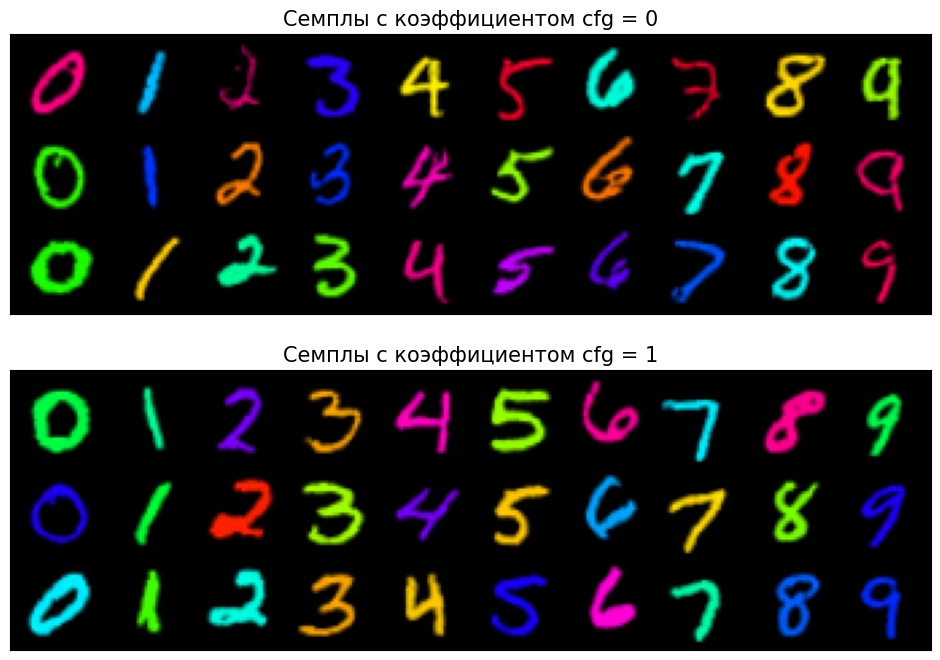

In [10]:
def visualize_cond_samples(model, params, n_samples=3, cfgs=[0.0, 0.5, 1.0, 2.0], **model_kwargs):
    fig, ax = plt.subplots(len(cfgs), figsize=(12, 8))
    for i in range(len(cfgs)):
        remove_ticks(ax[i])
        ax[i].set_title('Семплы с коэффициентом cfg = %.4g' % cfgs[i], fontsize=15)

    for i in range(len(cfgs)):
        cfg = cfgs[i]
        noise = torch.randn(n_samples * 10, 3, 32, 32, device=params['device'])
        class_labels = torch.eye(n=10, m=11).unsqueeze(0).repeat(n_samples, 1, 1).reshape(-1, 11).float().to(params['device'])
        params['cfg'] = cfgs[i]
        img, _ = sample_euler(model, noise, params, class_labels=class_labels, **model_kwargs)
        img = img * 0.5 + 0.5
        img_grid = make_grid(img, nrow=10)
        ax[i].imshow(img_grid.permute(1, 2, 0).detach().cpu())

sampling_params = {
    'device': 'cuda',
    'sigma_min': 0.02,
    'sigma_max': 80.0,
    'num_steps': 50,
    'rho': 7.0,
    'vis_steps': 1,
    'stochastic': False,
}

visualize_cond_samples(cond_model, sampling_params, cfgs=[0.0, 1.0])

## Непарные задачи перевода между доменами

Задача переноса стиля (перевода между доменами) ставит перед собой построение отображения $G(\mathbf{X})$ между двумя распределениями $p$ и $q$: то есть, такого отображения, что если $\mathbf{X} \sim p$, то $G(\mathbf{X}) \sim q$. Любое ли отображение с таким свойством подойдет? Нет, потому что в таком случае мы будем, например, считать решением задачи превращения кошки в собаку отображение $G$, которое переводит кошку в произвольную собаку, не имеющую ничего общего со входным изображением. Нам же хотелось бы гарантировать связь между входом и выходом. Дальше на курсе мы формализуем эту идею с помощью задачи оптимального транспорта.

Непарными же считаются задачи, в которых в данных нет явного соответствия между объектами двух доменов (например, в задаче превратить кошку в собаку или мужчину в женщину не очень понятно, как именно выбирать соответствующие пары). Здесь мы просто считаем, что нам дано два независимых набора данных, соответствующих $\mathbf{X} \sim p$ и $\mathbf{Y} \sim q$.

В этой части домашки мы будем решать задачу перевода между распределением $p(\mathbf{x})$, соответствующим распределению цифр из MNIST и $q(\mathbf{x})$, соответствующим распределению одного из классов MNIST (например, распределение троек).

## SDEdit

Оба метода основываются на одной и той же идее: если у нас есть диффузионная модель, способная генерировать тройки (например, безусловная модель, обученная на тройках, или условная модель, обученная на всем датасете), то чисто теоретически можно превратить любую цифру в тройку следующим образом:
* Зашумить цифру $\mathbf{X}$ до такого уровня $t$, что очертания, позволяющие определить цифру по $\mathbf{X} + t \varepsilon$, размываются, но остаются различимыми такие более общие черты, как цвет/толщина и т.д.;
* Запустить с помощью "троечной" диффузионной модели процесс расшумления, начав его с момента времени $t$ и семпла $\mathbf{X}_t$.

В идеале, генерация с помощью троечной диффузионной модели позволит нам получить правдоподобную тройку, а черты, оставшиеся в картинке после зашумления, позволят на каком-то уровне сохранить стиль исходной цифры. Данный метод называется [SDEdit](https://arxiv.org/abs/2108.01073).

## Задача 1

* **(0.2 балла)** Имплементируйте SDEdit для перевода произвольной цифры в цифру фиксированного класса (передав соответствующую метку в предобученную условную модель). Обратите внимание, что наша имплементация семплинга по схеме Эйлера ждет на вход $X_t / t$, поскольку в коде вход умножается на $t$;
* **(0.2 балла)** Проанализируйте, как меняется качество работы модели при изменении ее единственного гиперпараметра — уровня шума $t$, который прибавляется к исходной цифре. Возьмите по одной цифре из каждого класса и визуализируйте выходы метода при разных $t$. Поэкспериментируйте с разными $t$, чтобы визуализировать такие $t$, между которыми качественно меняется работа метода (например, сравнивать метод на $t = 79.0$ и $t = 80.0$ нет смысла). Как при изменении $t$ изменяется качество семплов и их похожесть на вход? Какой уровень шума $t$ вы бы предложили использовать?

In [11]:
# params: параметры семплинга по Эйлеру
# x_source: исходная картинка
# target_label: число, метка класса, в который нужно превратить объекты на входе
# гиперпараметр t передается в метод как params['sigma_max']



def sdedit(model, x_source, target_label, params):
    noise = torch.randn_like(x_source)
    x = (x_source * 2 - 1) + noise * params['sigma_max']
    labels = torch.zeros(x.shape[0], 11)
    labels[:, target_label] = 1
    out, _ = sample_euler(model, x/params['sigma_max'], params, class_labels=labels.cuda())
    out = out * 0.5 + 0.5
    return out


In [12]:
def visualize_transform(batch, batch_out, sigma_max):
    batch_cat = torch.cat((batch, batch_out), dim=0)
    image_grid = make_grid(batch_cat.cpu(), nrow=len(batch))

    fig, ax = plt.subplots(figsize=(3 * len(batch), 3))
    remove_ticks(ax)
    ax.set_title('Семплы с sigma_max = %.4g' % sigma_max, fontsize=15)
    ax.imshow(image_grid.permute(1, 2, 0))
    plt.show()

Сгенерим батч из цифр [0, ..., 9] по порядку, далее будет делать SDEEdit только от этих данных

In [13]:
X = []

for i in range(10):
    batch = next(iter(train_dataloader))
    x_source = batch[0].cuda()
    y_source = batch[1].cuda()
    idx = torch.where(y_source == i)[0][0]
    X.append(x_source[idx].unsqueeze(0))

x_source = torch.cat(X, axis = 0)

sampling_params = {
    'device': 'cuda',
    'sigma_min': 0.02,
    'sigma_max': ...,
    'num_steps': 50,
    'rho': 7.0,
    'vis_steps': 1,
    'stochastic': False,
    'cfg': 1.0
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0077049136..1.0069847].


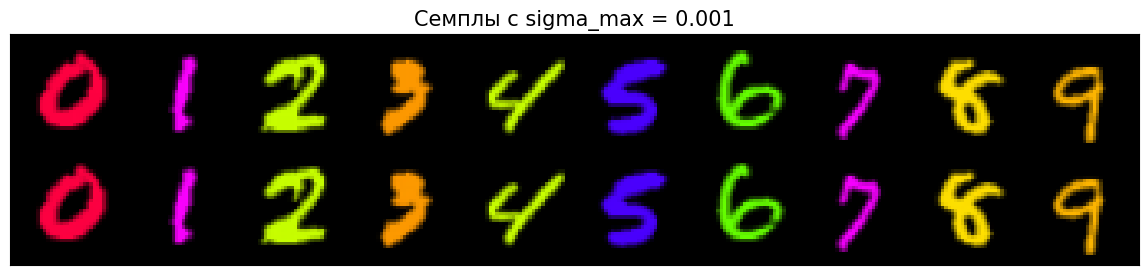

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.021357..1.0181447].


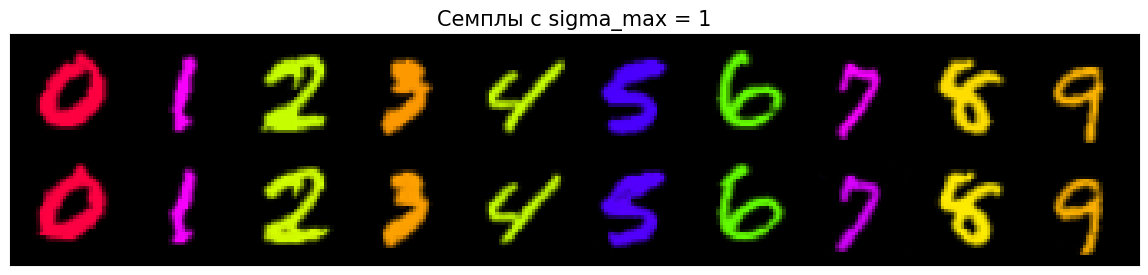

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.01469636..1.0225511].


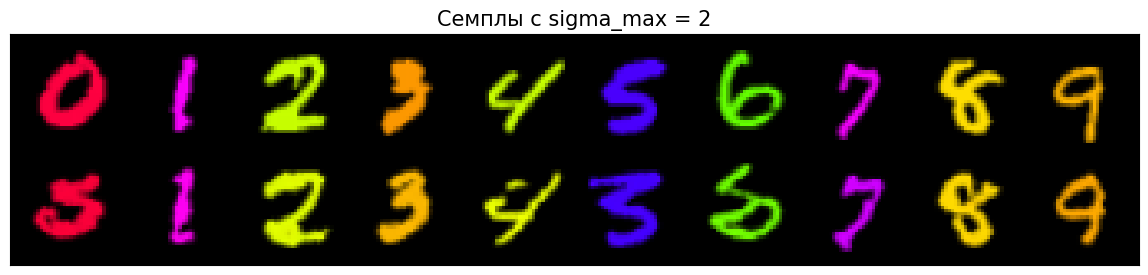

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.014553487..1.0145712].


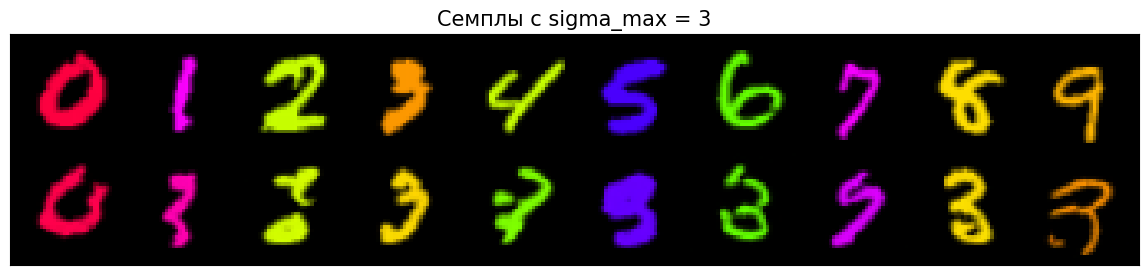

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.010685861..1.0150504].


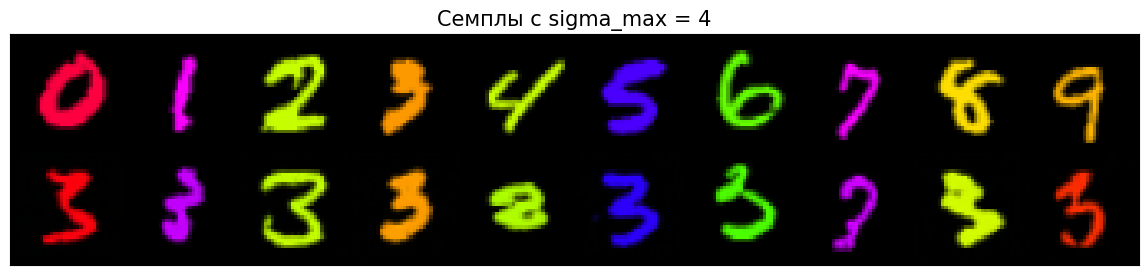

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02944088..1.0216646].


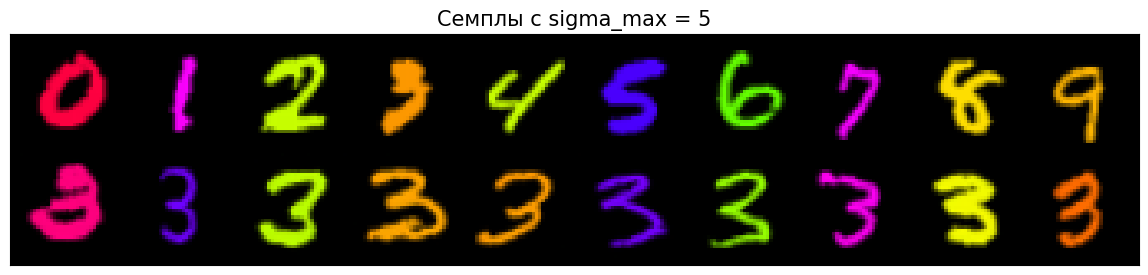

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.012109399..1.0243999].


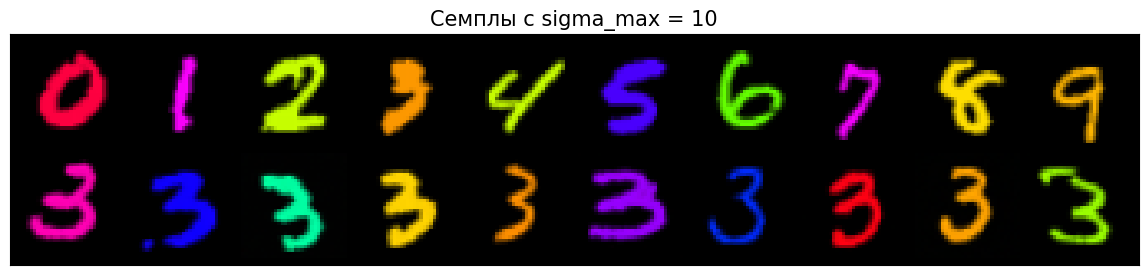

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.014841378..1.0311265].


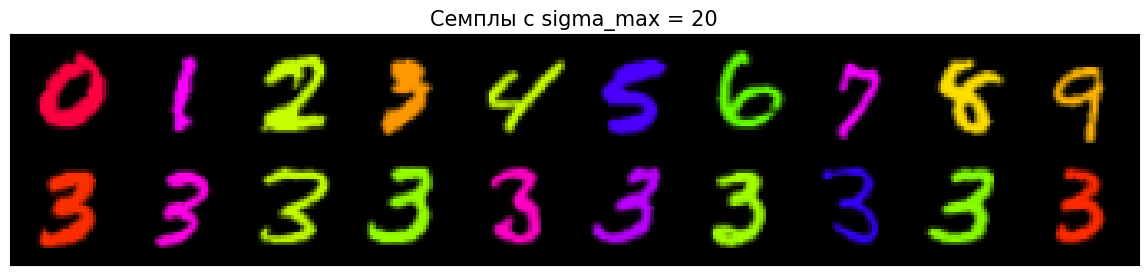

In [14]:
for sigma_max in [0.001, 1, 2, 3, 4, 5, 10, 20]:
    sampling_params['sigma_max'] = sigma_max
    x_out = sdedit(cond_model, x_source, target_label=3, params=sampling_params)
    visualize_transform(x_source, x_out, sigma_max)

Видно, что при t<3 сгенерированные семплы плохо похожи на 3, при t=3 в целом можно понять что это 3, при этом еще сохранен цвет
Если увеличивать t до 4, 5 то начинает немного меняться цвет сгенерированных картинок, при этом тройки становятся более правдоподобными 
Если брать уже t = 10, 20, то тройки правдоподобны, но не сохраняют стиль исходных цифр

Оптимальный t по этим картинкам я бы взял t = 4


## DDIB (Dual Diffusion Implicit Bridges)

Следующий метод, который мы рассмотрим, называется Dual Diffusion Implicit Bridges [(DDIB)](https://arxiv.org/abs/2203.08382). Он использует ту же идею, что SDEdit (зашумить семпл из исходного домена и расшумить его диффузионной моделью для целевого домена), но делает это более умно. Принципиальная проблема SDEdit состоит в том, что стохастическое зашумление всегда сопровождается потерей данных об исходном изображении (если $t$ слишком большое, то можно считать, что информации вообще никакой не остается). Если бы был способ детерминированного зашумления данных, это бы решило проблему, так как позволило бы превратить вход во что-то, что может принять на вход диффузионная модель для таргетного домена.

А такой способ у нас есть! Подойдет представление диффузионных моделей через обыкновенные дифференциальные уравнения: прямой процесс зашумления
$$
    \mathrm{d} \mathbf{X}_t = g(t) \mathrm{d} \mathbf{W}_t
$$
эквивалентен ОДУ
$$
    \mathrm{d} \mathbf{Y}_t = -\frac{g^2(t)}{2} \nabla \log p_t(\mathbf{Y}_t) \mathrm{d} t
$$
с точки зрения маргинальных распределений в каждый момент времени $t$. Тогда зашумить изображение из исходного домена можно решив соответствующее ОДУ с момента времени $0$ до момента времени $t$. Все, что для этого нужно, — иметь диффузионную модель для исходного домена (а такая модель в нашем сеттинге с условной моделью на MNIST'e есть).  Полученное зашумленное изображение, как и раньше, подается в диффузионную модель для целевого домена и расшумляется.

## Задача 2
* **(0.3 балла)** Реализуйте детерминированное зашумление изображения с помощью метода Эйлера, взяв $\sigma_t = t$ и $g(t) = \sqrt{2t}$ (именно эти параметры мы взяли в 5 лекции, с ними имплементировали схему Эйлера, которую потом скопировали во все 3 части домашки). На его основе релизуйте метод DDIB. Так как работаем мы с переводом произвольной цифры в, например, тройку, при зашумлении изображения мы будем подавать на вход сети его метку класса, а при расшумлении — метку целевого класса. При зашумлении тоже имеет смысл использовать CFG.

* Как и в SDEdit, обратите внимание, что наша имплементация семплинга по схеме Эйлера ждет на вход $X_t / t$, поскольку в коде вход умножается на $t$;

* **(0.1 балл)** Визуализируйте траекторию зашумления и расшумления изображения при выборе максимального $t = T$ (80.0 в наших экспериментах). Похож ли "детерминированный шум", полученный при кодировании входа, на семпл из нормального распределения? При визуализации траектории имеет смысл нормировать промежуточные изображения (например, так, как это делается в лекции 5).

  
* **(0.2 балла, копипаста из SDEdit)** Проанализируйте, как меняется качество работы модели при изменении ее единственного гиперпараметра — уровня шума $t$, до которого кодируется исходная картинка. Возьмите по одной цифре из каждого класса и визуализируйте выходы метода при разных $t$. Поэкспериментируйте с разными $t$, чтобы визуализировать такие $t$, между которыми качественно меняется работа метода. Как при изменении $t$ изменяется качество семплов и их похожесть на вход? Какой уровень шума $t$ вы бы предложили использовать?

In [15]:
sampling_params = {
    'device': 'cuda',
    'sigma_min': 0.02,
    'sigma_max': ...,
    'num_steps': 50,
    'rho': 7.0,
    'vis_steps': 1,
    'cfg': 1.0
}

def encode_euler(model, x_source, params, class_labels=None, **model_kwargs):
    num_steps = params['num_steps']
    vis_steps = params['vis_steps']
    t_steps = get_timesteps(params) # здесь t убывают!
    x = x_source * 2 - 1
    # x = x_source
    
        
    labels = torch.zeros(x.shape[0], 11)
    labels[np.arange(x.shape[0]), class_labels] = 1

    x_history = [normalize(x)]
    with torch.no_grad():
        for i in range(len(t_steps) - 1):
            t_cur = t_steps[len(t_steps) - i - 1]
            t_next = t_steps[len(t_steps) - i - 2]
            t_net = t_steps[len(t_steps) - i - 1] * torch.ones(x.shape[0], device=params['device'])
            
            if t_cur == 0:
                x = x - velocity_from_denoiser(x, model, t_net + 1e-2, class_labels=labels.cuda(), stochastic=False, cfg=params['cfg'], **model_kwargs) * abs(t_next - t_cur)
            else:
                x = x - velocity_from_denoiser(x, model, t_net, class_labels=labels.cuda(), stochastic=False, cfg=params['cfg'], **model_kwargs) * abs(t_next - t_cur)
    
            x_history.append(normalize(x).view(-1, 3, *x.shape[2:]))

    x_history = [x_history[0]] + x_history[::-(num_steps // (vis_steps - 2))][::-1] + [x_history[-1]]

    return x, x_history

def ddib(model, x_source, source_label, target_label, params):
    x, traj_enc = encode_euler(model, x_source, params, source_label)
    labels = torch.zeros(x.shape[0], 11)
    labels[np.arange(x.shape[0]), target_label] = 1
    out, traj_dec = sample_euler(model, x/params['sigma_max'], params, class_labels=labels.cuda())
    out = out * 0.5 + 0.5
    return out, torch.cat(traj_enc + traj_dec, dim = 0)

In [16]:
batch_size = 10

def visualize_traj(traj):
    n_vis = traj.shape[0]/batch_size

    traj[np.arange(traj.shape[0])] = traj[batch_size * (np.arange(traj.shape[0])%n_vis) + np.arange(traj.shape[0])//n_vis]
    batch_cat = traj * 0.5 + 0.5
    image_grid = make_grid(batch_cat.cpu(), nrow=int(n_vis))

    fig, ax = plt.subplots(figsize=(3 * 10, 3 * 5))
    remove_ticks(ax)
    ax.imshow(image_grid.permute(1, 2, 0))
    plt.show()

In [17]:
X = []
for i in range(10):
    batch = next(iter(train_dataloader))
    x_source = batch[0].cuda()
    y_source = batch[1].cuda()
    idx = torch.where(y_source == i)[0][0]
    X.append(x_source[idx].unsqueeze(0))
x_source = torch.cat(X, axis = 0)

Нарисуем траектории детерменированного зашумления до t = 80 и детерменированного расшумления 

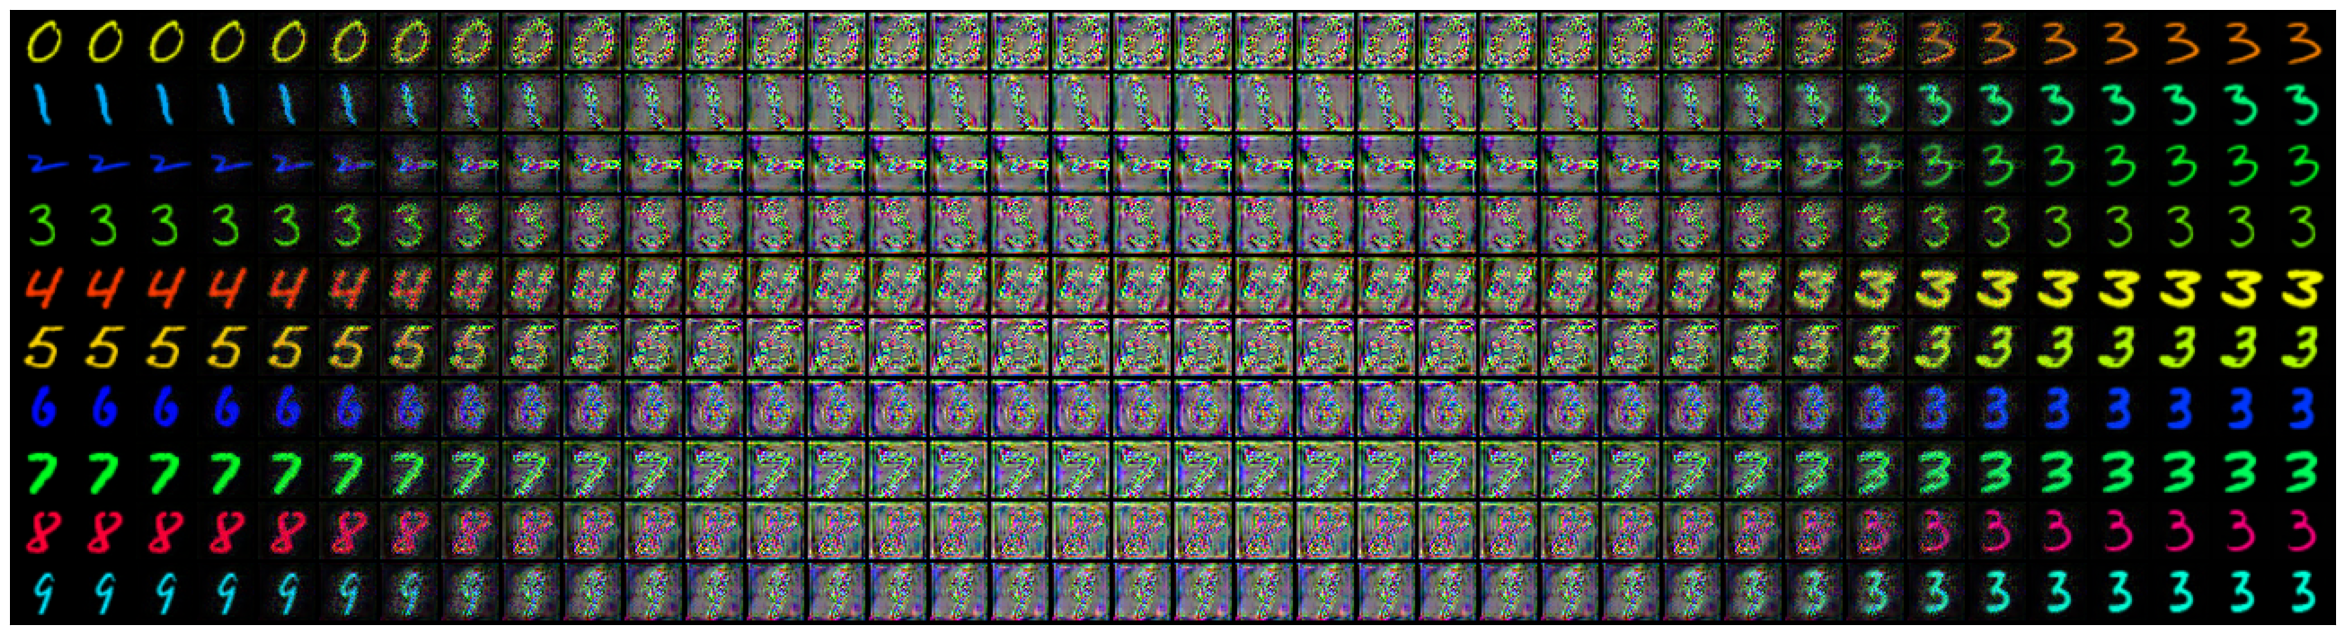

In [18]:
sampling_params = {
    'device': 'cuda',
    'sigma_min': 0.02,
    'sigma_max': 80,
    'num_steps': 50,
    'rho': 7.0,
    'vis_steps': 15,
    'stochastic': False,
    'cfg': 1.0
}


x_out, traj = ddib(cond_model, x_source, np.arange(10), target_label=np.ones(10)*3, params=sampling_params)

visualize_traj(traj)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.006577134..1.0001192].


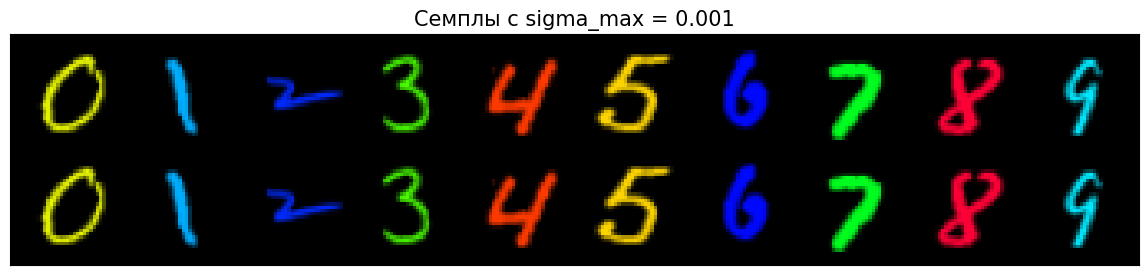

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.009266138..1.0032674].


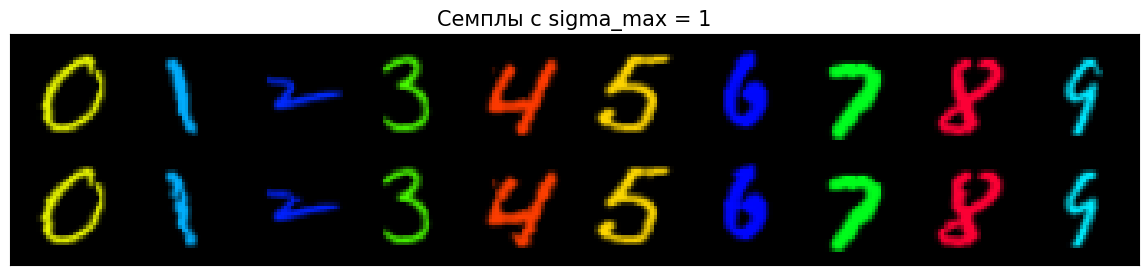

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.017626226..1.0087848].


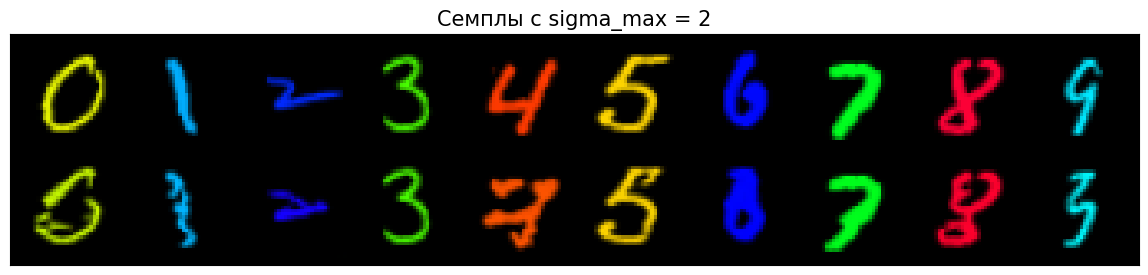

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.021688402..1.0111003].


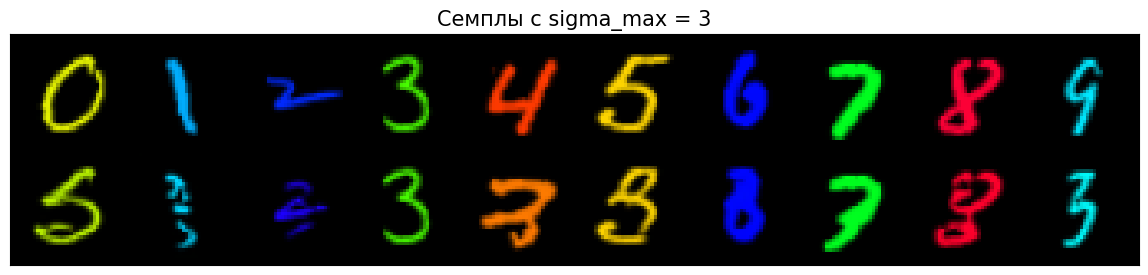

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.016513765..1.0134592].


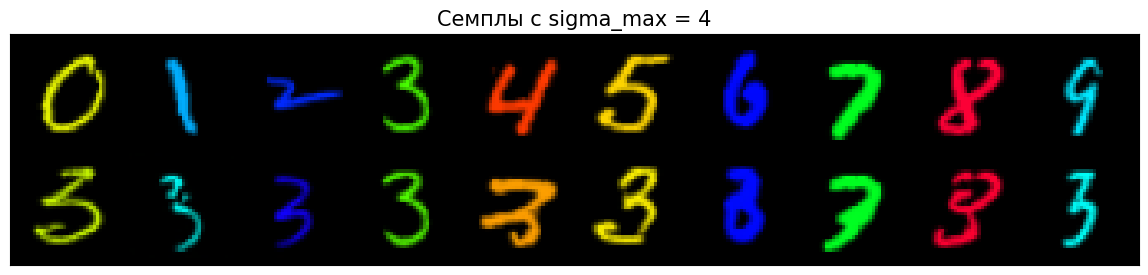

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.016433656..1.0140104].


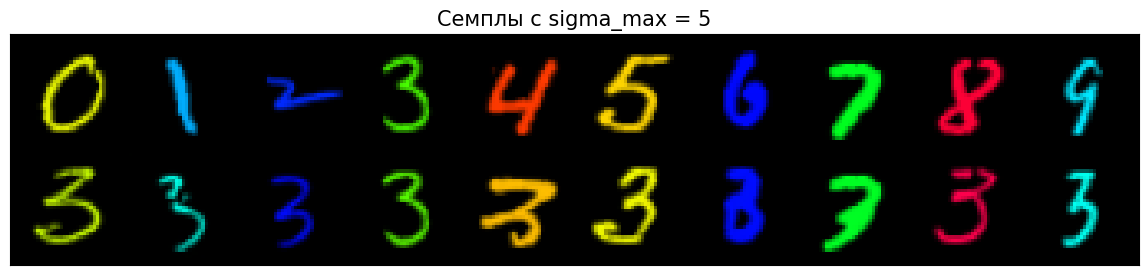

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.019580245..1.0101955].


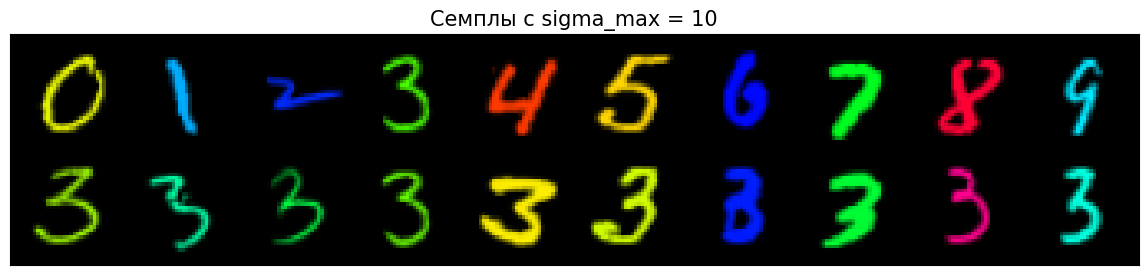

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.023503661..1.0109459].


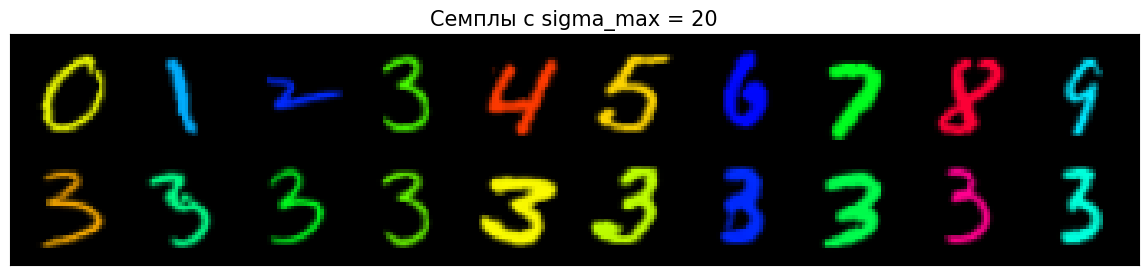

In [19]:
sampling_params = {
    'device': 'cuda',
    'sigma_min': 0.02,
    'sigma_max': 80,
    'num_steps': 50,
    'rho': 7.0,
    'vis_steps': 15,
    'stochastic': False,
    'cfg': 1.0
}

for sigma_max in [0.001, 1, 2, 3, 4, 5, 10, 20]:
    sampling_params['sigma_max'] = sigma_max
    x_out, traj = ddib(cond_model, x_source, np.arange(10), target_label=np.ones(10)*3, params=sampling_params)
    visualize_transform(x_source, x_out, sigma_max)

Видно, что при t<4 сгенерированные семплы плохо похожи на 3, при t=4 в целом можно понять что это 3, при этом еще сохранен цвет
Если увеличивать t то начинает немного меняться цвет сгенерированных картинок, при этом тройки становятся более правдоподобными 
Если брать уже t = 10, 20, то тройки правдоподобны, но не сохраняют стиль исходных цифр

Оптимальный t по этим картинкам я бы взял t = 5

Отличие от SDEEDIT в том, что при равных sigma_max у него более похожие на начальные картинки


## Задача 3 (бонус, 0.5 балла)

Возьмите по 3-5 (адекватных) значений $t$ для каждого из двух методов. Для каждого $t$ запустите метод (с тройками в качестве целевого домена) на подмножестве тестового датасета MNIST (1000-2000 картинок) и посчитайте две метрики:
* Средняя по датасету "похожесть" между входом и выходом, посчитанная как попиксельная $L_2$ норма разности;
* FID между сгенерированными тройками и тройками из трейн датасета (предпосчитанные статистики лежат в *cmnist_train_3.npz*).

Визуализируйте полученные метрики в виде двумерного scatter plot с осями, соответствующими метрикам, и прокомментируйте результаты. Какой из методов достигает лучшего баланса между качеством семплов и похожестью входа на выход?

In [20]:
test_dataloader = DataLoader(data_test, batch_size=64, shuffle=True)
batch_size = next(iter(train_dataloader))[0].shape[0]

In [21]:
import os, shutil
from tqdm import tqdm
# сохраним семплы из модели для дальнейшего подсчета FID


sampling_params = {
    'device': 'cuda',
    'sigma_min': 0.02,
    'sigma_max': ...,
    'num_steps': 50,
    'rho': 7.0,
    'vis_steps': 1,
    'stochastic': False,
    'cfg': 1.0
}

def save_model_samples_ddib(name, model, params, batch_size, num_samples, **model_kwargs):
    if os.path.exists(name):
        shutil.rmtree(name)

    os.makedirs(name, exist_ok=True)
    count = 0

    with tqdm(total= num_samples) as pbar:
        while count < num_samples:
            cur_batch_size = min(num_samples - count, batch_size)
            batch = next(iter(train_dataloader))
            x_source = batch[0][:cur_batch_size].cuda()
            y_source = batch[1][:cur_batch_size].cuda()
            out, _ = ddib(model, x_source, y_source, target_label=3, params=params)
            out = (out * 255).clip(0, 255).to(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()
            for i in range(out.shape[0]):
                img = Image.fromarray(out[i])
                n_digits = len(str(count))
                img_name = (6 - n_digits) * '0' + str(count) + '.png'
                img.save(os.path.join(name, img_name))
                count += 1
                pbar.update(1)
                pbar.set_description('%d images saved' % (count,))
                
def save_model_samples_sdeedit(name, model, params, batch_size, num_samples, **model_kwargs):
    if os.path.exists(name):
        shutil.rmtree(name)

    os.makedirs(name, exist_ok=True)
    count = 0

    with tqdm(total= num_samples) as pbar:
        while count < num_samples:
            cur_batch_size = min(num_samples - count, batch_size)
            batch = next(iter(train_dataloader))
            x_source = batch[0][:cur_batch_size].cuda()
            out = sdedit(model, x_source, target_label=3, params=params)
            out = (out * 255).clip(0, 255).to(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()
            for i in range(out.shape[0]):
                img = Image.fromarray(out[i])
                n_digits = len(str(count))
                img_name = (6 - n_digits) * '0' + str(count) + '.png'
                img.save(os.path.join(name, img_name))
                count += 1
                pbar.update(1)
                pbar.set_description('%d images saved' % (count,))

In [22]:
for sigma_max in [2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8]:
    sampling_params['sigma_max'] = sigma_max
    save_model_samples_ddib(f'ddib_samples_{int(sigma_max)}_{int(10*sigma_max) % 10}', cond_model, sampling_params, batch_size=batch_size, num_samples=2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

2000 images saved: 100%|██████████| 2000/2000 [02:31<00:00, 13.24it/s]


In [23]:
for sigma_max in [2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8]:
    sampling_params['sigma_max'] = sigma_max
    save_model_samples_sdeedit(f'sdeedit_samples_{int(sigma_max)}_{int(10*sigma_max) % 10}', cond_model, sampling_params, batch_size=batch_size, num_samples=2000)

2000 images saved: 100%|██████████| 2000/2000 [01:15<00:00, 26.41it/s]


In [24]:
# возьмем реализацию подсчета FID из EDM
%cd edm
from fid import calculate_inception_stats, calculate_fid_from_inception_stats
from dnnlib.util import open_url
%cd ..

def calc_fid(image_path, ref_path, num_expected, batch):
    with open_url(ref_path) as f:
        ref = dict(np.load(f))

    mu, sigma = calculate_inception_stats(image_path=image_path, num_expected=num_expected, max_batch_size=batch)
    fid = calculate_fid_from_inception_stats(mu, sigma, ref['mu'], ref['sigma'])
    return fid

/home/sudakovcom/Desktop/diffusion/HW_1/edm
/home/sudakovcom/Desktop/diffusion/HW_1


In [27]:
sigma_maxs = [2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8]
fids_ddib = []
fids_sdeedit = []

for sigma_max in [2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8]:
    fid = calc_fid(f'ddib_samples_{int(sigma_max)}_{int(10*sigma_max) % 10}', 'cmnist_train_3.npz', num_expected=2000, batch=128)
    fids_ddib.append(fid)
    fid = calc_fid(f'sdeedit_samples_{int(sigma_max)}_{int(10*sigma_max) % 10}', 'cmnist_train_3.npz', num_expected=2000, batch=128)
    fids_sdeedit.append(fid)
    
fids_ddib = np.array(fids_ddib)
fids_sdeedit = np.array(fids_sdeedit)

Loading Inception-v3 model...
Loading images from "ddib_samples_2_5"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:04<00:00,  3.84batch/s]


Loading Inception-v3 model...
Loading images from "sdeedit_samples_2_5"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:04<00:00,  3.83batch/s]


Loading Inception-v3 model...
Loading images from "ddib_samples_3_0"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:04<00:00,  3.83batch/s]


Loading Inception-v3 model...
Loading images from "sdeedit_samples_3_0"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:04<00:00,  3.83batch/s]


Loading Inception-v3 model...
Loading images from "ddib_samples_3_5"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:04<00:00,  3.82batch/s]


Loading Inception-v3 model...
Loading images from "sdeedit_samples_3_5"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:04<00:00,  3.82batch/s]


Loading Inception-v3 model...
Loading images from "ddib_samples_4_0"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:04<00:00,  3.82batch/s]


Loading Inception-v3 model...
Loading images from "sdeedit_samples_4_0"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:04<00:00,  3.81batch/s]


Loading Inception-v3 model...
Loading images from "ddib_samples_4_5"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:04<00:00,  3.82batch/s]


Loading Inception-v3 model...
Loading images from "sdeedit_samples_4_5"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:04<00:00,  3.82batch/s]


Loading Inception-v3 model...
Loading images from "ddib_samples_5_0"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:04<00:00,  3.81batch/s]


Loading Inception-v3 model...
Loading images from "sdeedit_samples_5_0"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:04<00:00,  3.80batch/s]


Loading Inception-v3 model...
Loading images from "ddib_samples_5_5"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:04<00:00,  3.81batch/s]


Loading Inception-v3 model...
Loading images from "sdeedit_samples_5_5"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:04<00:00,  3.80batch/s]


Loading Inception-v3 model...
Loading images from "ddib_samples_6_0"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:04<00:00,  3.81batch/s]


Loading Inception-v3 model...
Loading images from "sdeedit_samples_6_0"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:04<00:00,  3.80batch/s]


Loading Inception-v3 model...
Loading images from "ddib_samples_6_5"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:04<00:00,  3.80batch/s]


Loading Inception-v3 model...
Loading images from "sdeedit_samples_6_5"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:04<00:00,  3.80batch/s]


Loading Inception-v3 model...
Loading images from "ddib_samples_7_0"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:04<00:00,  3.80batch/s]


Loading Inception-v3 model...
Loading images from "sdeedit_samples_7_0"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:04<00:00,  3.80batch/s]


Loading Inception-v3 model...
Loading images from "ddib_samples_7_5"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:04<00:00,  3.81batch/s]


Loading Inception-v3 model...
Loading images from "sdeedit_samples_7_5"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:04<00:00,  3.80batch/s]


Loading Inception-v3 model...
Loading images from "ddib_samples_8_0"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:04<00:00,  3.80batch/s]


Loading Inception-v3 model...
Loading images from "sdeedit_samples_8_0"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:04<00:00,  3.80batch/s]


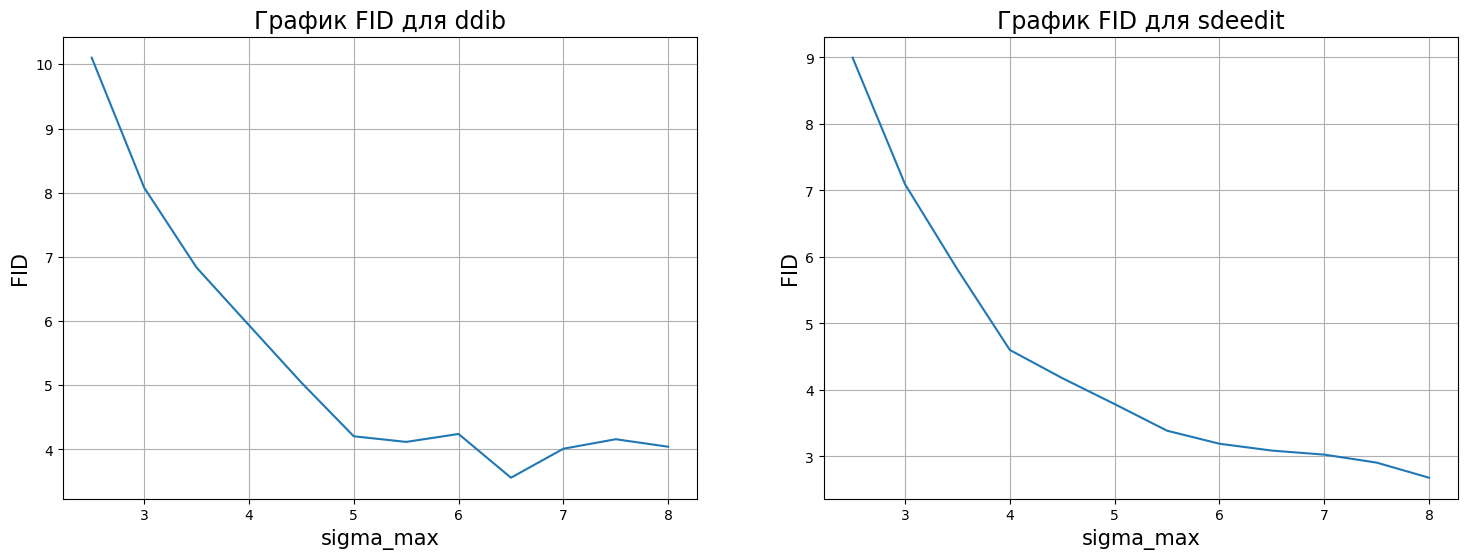

In [31]:
plt.figure(figsize = (18, 6))

plt.subplot(1, 2, 1)
plt.plot(sigma_maxs, fids_ddib)
plt.title('График FID для ddib', fontsize=17)
plt.xlabel('sigma_max', fontsize=15)
plt.ylabel('FID', fontsize=15)
plt.grid()


plt.subplot(1, 2, 2)
plt.plot(sigma_maxs, fids_sdeedit)
plt.title('График FID для sdeedit', fontsize=17)
plt.xlabel('sigma_max', fontsize=15)
plt.ylabel('FID', fontsize=15)
plt.grid()

plt.show()

Получается что у sdeedit лучше FID при одинаковых sigma_max

In [37]:
def count_mse_ddib(model, params, batch_size, num_samples, **model_kwargs):
    count = 0
    MSE_sum = 0

    while count < num_samples:
        cur_batch_size = min(num_samples - count, batch_size)
        batch = next(iter(train_dataloader))
        x_source = batch[0][:cur_batch_size].cuda()
        y_source = batch[1][:cur_batch_size].cuda()
        out, _ = ddib(model, x_source, y_source, target_label=3, params=params)
        count += cur_batch_size
        MSE_sum += ((x_source - out)**2).sum()
        
    return MSE_sum / count / 3 / 32 / 32
            
                
def count_mse_sdeedit(model, params, batch_size, num_samples, **model_kwargs):
    count = 0
    MSE_sum = 0

    while count < num_samples:
        cur_batch_size = min(num_samples - count, batch_size)
        batch = next(iter(train_dataloader))
        x_source = batch[0][:cur_batch_size].cuda()
        out = sdedit(model, x_source, target_label=3, params=params)
        count += cur_batch_size
        MSE_sum += ((x_source - out)**2).sum()
            
    return MSE_sum / count / 3 / 32 / 32

In [50]:
sigma_maxs = [2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8]
mse_ddib = []
mse_sdeedit = []

for sigma_max in [2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8]:
    sampling_params['sigma_max'] = sigma_max
    mse = count_mse_ddib(cond_model, sampling_params, batch_size, 2000)
    mse_ddib.append(mse)
    mse = count_mse_sdeedit(cond_model, sampling_params, batch_size, 2000)
    mse_sdeedit.append(mse)
    
mse_ddib = np.array([el.item() for el in mse_ddib])
mse_sdeedit = np.array([el.item() for el in mse_sdeedit])

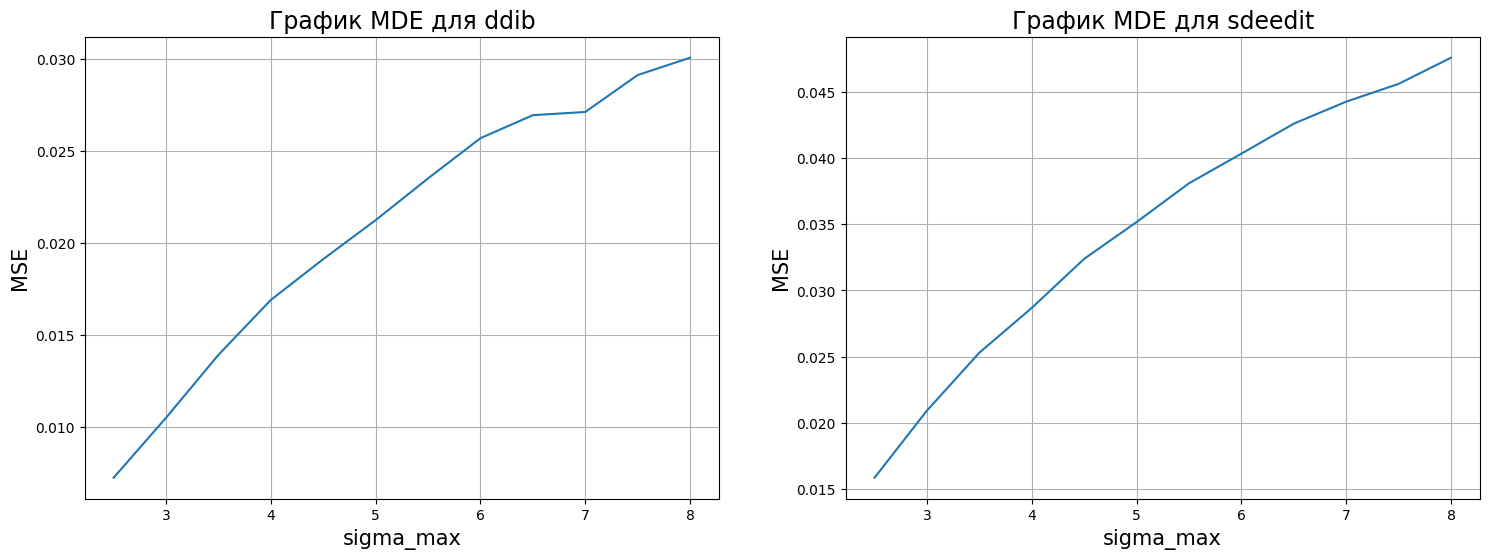

In [51]:
plt.figure(figsize = (18, 6))

plt.subplot(1, 2, 1)
plt.plot(sigma_maxs, mse_ddib)
plt.title('График MDE для ddib', fontsize=17)
plt.xlabel('sigma_max', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.grid()


plt.subplot(1, 2, 2)
plt.plot(sigma_maxs, mse_sdeedit)
plt.title('График MDE для sdeedit', fontsize=17)
plt.xlabel('sigma_max', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.grid()

plt.show()

Получается что у методов при одинаковых FID у DDIB более похожие картинки на исходные